<a href="https://colab.research.google.com/github/Frsagco/ML_denoising/blob/main/Denoising_using_GAN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising GAN - Machine Learning for Vision and Multimedia (01URPOV)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas
import numpy as np
from math import log10, sqrt, ceil
import os, shutil
import PIL
import PIL.Image
import tensorflow_datasets as tfds
import cv2
from tensorflow.keras import Sequential, Model, Input, utils
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from scipy.stats import norm, bernoulli, poisson
from skimage.util import random_noise
from google.colab.patches import cv2_imshow
import scipy.stats as stats
import keras.backend as K
from keras.applications.vgg19 import VGG19
from pycocotools.coco import COCO
import skimage.io as io
from skimage.metrics import structural_similarity as ssim
from tensorflow import image
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pathlib
import time
from google.colab import drive
from google.colab import files
import sys
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## General Utils
Global variable useful for Colab and Google Drive authentication. 

In [ ]:
# GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# RAM 
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon Jun 27 06:34:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def print_stars():
  print("**********************************************************************************")

## Import COCO dataset

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
default_dir='drive/MyDrive/ML-denoising'
dataType='val2017'
annFile='{}/annotations/stuff_{}.json'.format(default_dir,dataType)
print(annFile)

# initialize COCO api for instance annotations
coco=COCO(annFile)
cats = coco.loadCats(coco.getCatIds())
nms = set([cat['supercategory'] for cat in cats])
catIds = coco.getCatIds(catNms=nms);
imgIds = coco.getImgIds(catIds = catIds );
imgIds = coco.getImgIds(imgIds = imgIds)
image_count = len(imgIds) # takes images from the entire COCO dataset
indexes = np.random.randint(0,len(imgIds),image_count)

drive/MyDrive/ML-denoising/annotations/stuff_val2017.json
loading annotations into memory...
Done (t=1.76s)
creating index...
index created!


### Download and load Dataset

Saving images as array of values between [-1,1]

Images are randomly cropped into a window of size (256,256)

In [ ]:
# utility function to plot some figures
def plot_figures(x, n, figsize=(20,20), dpi=20):
  plt.figure(figsize=figsize)
  if n == 1:
    img=x[:,:,:]
    # rescale for visualization purposes
    img = ((img*127.5) + 127.5).astype("uint8")
    plt.imshow(img)
  else:
    for i in range(n):

      plt.subplot(1,n,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      img=x[i,:,:,:]
      # rescale for visualization purposes
      img = ((img*127.5) + 127.5).astype("uint8")
      plt.imshow(img)

  plt.show()

In [ ]:
def set_directories(d_source):
  # Create directories if are not not present 

  d_dataset='dataset'
  path_dataset = os.path.join(d_source, d_dataset)
  if(not os.path.exists(path_dataset)):
    os.mkdir(path_dataset)

  d_test_dataset='test'
  path_test = os.path.join(path_dataset, d_test_dataset)
  if(not os.path.exists(path_test)):
    os.mkdir(path_test)

  d_train_dataset='train'
  path_train = os.path.join(path_dataset, d_train_dataset)
  if(not os.path.exists(path_train)):
    os.mkdir(path_train)

  return path_train, path_test

In [ ]:
def is_dataset_on_drive(d_source):
  d_dataset='dataset'
  path_dataset = os.path.join(d_source, d_dataset)
  if(not os.path.exists(path_dataset)):
    print(" [LOAD]: No dataset on Drive.") 
    return False, "", ""
  
  d_test_dataset='test'
  path_test = os.path.join(path_dataset, d_test_dataset)
  if(not os.path.exists(path_test)):
    print(" [LOAD]: No test set on Drive.") 
    return False, "", ""
  
  d_train_dataset='train'
  path_train = os.path.join(path_dataset, d_train_dataset)
  if(not os.path.exists(path_train)):
    print(" [LOAD]: No train set on Drive.") 
    return False, "", ""
  
  return True, path_test, path_train  

In [ ]:
def reset_datasets(path_train, path_test, ram_parallel):
  # Reset datasets from path
  if((not os.path.exists(path_train)) and (not os.path.exists(path_test))):
    print(" [LOAD]: No train and test datasets found.")
    return

  i=0
  while True:
    path_i="train"+str(i)+".npy"
    path_train_i=os.path.join(path_train, path_i)
    if(os.path.exists(path_train_i)):
      os.remove(path_train_i)
      i=i+1
    else:
      break
  i=0
  while True:
    path_i="test"+str(i)+".npy"
    path_test_i=os.path.join(path_test, path_i)
    if(os.path.exists(path_test_i)):
      os.remove(path_test_i)
      i=i+1
    else:
      break

  return 

In [ ]:
def calculate_range(image_count_train, image_count_test, ram_parallel):
  max_images_on_file=np.zeros((2, max(ram_parallel[0], ram_parallel[1])))

  max_range_on_file=ceil(image_count_test/ram_parallel[1])
  for i in range(ram_parallel[1]):
    if image_count_test-max_range_on_file < 0 :
      max_images_on_file[1][i]=int(image_count_test)
      break
    else:
      max_images_on_file[1][i]=int(max_range_on_file)
      image_count_test=image_count_test-max_range_on_file

  for i in range(ram_parallel[1]):
    if max_images_on_file[1][i]==0 :
      ram_parallel[1]=i
      break

  max_range_on_file=ceil(image_count_train/ram_parallel[0])
  for i in range(ram_parallel[0]):
    if image_count_train-max_range_on_file < 0 :
      max_images_on_file[0][i]=image_count_train
      break
    else:
      max_images_on_file[0][i]=max_range_on_file
      image_count_train=image_count_train-max_range_on_file
    
  for i in range(ram_parallel[0]):
    if max_images_on_file[0][i]==0 :
      ram_parallel[0]=i
      break

  return max_images_on_file

In [ ]:
def print_calculated_range(max_images_on_file, ram_parallel):
  count_test=0
  count_train=0

  string_train=" [META]: "
  for i in range(ram_parallel[0]):
    string_train=string_train+"train"+str(i)+":["+str(int(max_images_on_file[0][i]))+"]"
    if i is not ram_parallel[0]-1:
      string_train=string_train+" "
    count_train=count_train+int(max_images_on_file[0][i])
  string_train=string_train+"]"
  print(string_train)
  print(" [META]: Count train: "+str(count_train))

  string_test=" [META]: "
  for i in range(ram_parallel[1]):
    string_test=string_test+"test"+str(i)+":["+str(int(max_images_on_file[1][i]))+"]"
    if i is not ram_parallel[1]-1:
      string_test=string_test+" "
    count_test=count_test+int(max_images_on_file[1][i])
  string_test=string_test+"]"
  print(string_test)
  print(" [META]: Count test: "+str(count_test))

  return

In [ ]:
def load_dataset_from_drive(d_source, n, image_count_train, image_count_test, ram_parallel, max_images_on_file):
  
  check, path_test, path_train=is_dataset_on_drive(d_source)
  if check is not True:
    print(" [LOAD]: You need to download COCO Dataset from API and upload on Drive.")
    return
  
  print(" [LOAD]: Loading test set...")

  ##### TEST SET #####
  test=np.zeros((image_count_test, n, n, 3)) # values between [-1,1]
  i=0
  j=0

  for i in range(ram_parallel[1]):
    k=int(max_images_on_file[1][i])
  
    path_i="test"+str(i)+".npy"
    path_test_i=os.path.join(path_test, path_i)
    if(not os.path.exists(path_test_i)):
      break

    test[j:j+k]=np.load(path_test_i)
    j=j+k

    percentage = "{:.2%}".format(j/image_count_test)
    message="[LOAD]: Test dataset load process: "+percentage
    print("\r", message, end="")

  print(" ")
  print(" [LOAD]: Completed.")
  print_stars()
  print(" [LOAD]: Loading train set...")
    
  ##### TRAIN SET #####
  train=np.zeros((image_count_train, n, n, 3)) # values between [-1,1]
  i=0
  j=0

  for i in range(ram_parallel[0]):
    k=int(max_images_on_file[0][i])
  
    path_i="train"+str(i)+".npy"
    path_train_i=os.path.join(path_train, path_i)
    if(not os.path.exists(path_train_i)):
      break

    train[j:j+k]=np.load(path_train_i)
    j=j+k
    percentage = "{:.2%}".format(j/image_count_train)
    message="[LOAD]: Train dataset load process: "+percentage
    print("\r", message, end="")

  print(" ")
  print(" [LOAD]: Completed.")
  print_stars()
  
  return train, test

In [ ]:
def load_dataset_from_coco(d_source, n, image_count_train, image_count_test, image_count, ram_parallel, max_images_on_file):
  # Saving datasets of test and train on many .npy files on Google Drive subdirectories

  # Creating subdirectories where locate datasets
  path_train, path_test=set_directories(d_source)
  # Resetting datasets already presents on
  
  reset_datasets(path_train, path_test, ram_parallel)

  print(" [LOAD]: Downloading train set ...")

  ##### TRAIN SET DOWNLOAD #####
  train=np.zeros((image_count_train, n, n, 3)) # values between [-1,1]
  index_train=set()
  
  k=0
  i=0
  j=0
  z=0
  last_saved=0

  # k = index counting image on train saved
  # i = index taking images from COCO (i!=k since not all images are right on dimension)
  # j = index of files
  # z = contator used for checking if it's necessary to write down on file or not
  # last_saved = index of last element of train on files
  
  while (k < image_count_train):
    ind=np.random.randint(0, image_count)
    img = coco.loadImgs(imgIds[ind])[0]
    i=i+1 
    image = io.imread(img['coco_url'])
    if len(image.shape) == 3 and image.shape[0]>=256 and image.shape[1]>=256 :
      # random crop
      x = np.random.randint(0,image.shape[0]-255)
      y = np.random.randint(0,image.shape[1]-255)
      image = image[x:x+n, y:y+n, 0:3]
      image = (image - 127.5) / 127.5
      train[k]=image
      z=z+1
      k=k+1
      percentage = "{:.2%}".format(k/image_count_train)
      message="[LOAD]: Train dataset download process: "+percentage
      print("\r", message, end="")

      if(z == max_images_on_file[0][j]):
        path_i="train"+str(j)+".npy"
        path_train_i=os.path.join(path_train, path_i)
        np.save(path_train_i, train[last_saved:(last_saved+int(max_images_on_file[0][j]))])
        last_saved=last_saved+int(max_images_on_file[0][j])
        j=j+1
        z=0
      
      index_train.add(ind)

  print(" ")
  print(" [LOAD]: Download completed.")
  print("***********************************************************************************")

  ##### TEST SET DOWNLOAD #####
  print(" [LOAD]: Downloading test set ...")
  test=np.zeros((image_count_test, n, n, 3)) # values between [-1,1]
  k=0
  i=0
  j=0
  z=0
  last_saved=0

  # k = index counting image on test saved
  # i = index taking images from COCO (i!=k since not all images are right on dimension)
  # j = index of files
  # z = contator used for checking if it's necessary to write down on file or not
  # last_saved = index of last element of test on files
  
  while (k < image_count_test):
    ind=np.random.randint(0, image_count)
    if ind in(index_train):
      continue

    img = coco.loadImgs(imgIds[ind])[0]
    i=i+1 
    image = io.imread(img['coco_url'])
    if len(image.shape) == 3 and image.shape[0]>=256 and image.shape[1]>=256 :
      # random crop
      x = np.random.randint(0,image.shape[0]-n+1)
      y = np.random.randint(0,image.shape[1]-n+1)
      image = image[x:x+n, y:y+n, 0:3]
      image = (image - 127.5) / 127.5
      test[k]=image
      z=z+1
      k=k+1

      percentage = "{:.2%}".format(k/image_count_test)
      message="[LOAD]: Test dataset download process: "+percentage
      print("\r", message, end="")
 
      if(z == max_images_on_file[1][j]):
        path_i="test"+str(j)+".npy"
        path_test_i=os.path.join(path_test, path_i)
        np.save(path_test_i, test[last_saved:(last_saved+int(max_images_on_file[1][j]))])
        last_saved=last_saved+int(max_images_on_file[1][j])
        j=j+1
        z=0

  print(" ")
  print(" [LOAD]: Download completed.")
  print("**********************************************************************************")

  return train, test

## Adding Noise
This function chooses randomly one kind of noise among Gaussian, Salt & Pepper and Speckle. 

Since we want more robustness, we decided to choose the intensity of the noise by using a uniform distribution.

In [ ]:
def apply_noise_to_image(img):
  noise_choises=["gaussian", "s&p", "speckle"];
  img = ((img*127.5) + 127.5).astype("uint8")
  index=np.random.randint(0,3);

  if noise_choises[index]=="gaussian":
    mean=0;

    lower, upper = 0.0051, 0.0081
    var=np.random.uniform(low=lower,high=upper)
    
    noise_img = random_noise(img, mode='gaussian', mean=mean, var=var)

  elif noise_choises[index]=="s&p":
    lower, upper = 0.011, 0.021
    sigma = 0.002

    amount=np.random.uniform(low=lower,high=upper)
    noise_img = random_noise(img, mode='s&p', amount=amount)

  elif noise_choises[index]=="speckle":
    lower, upper = 0.0051, 0.021
    sigma = 0.003

    var=np.random.uniform(low=lower,high=upper)
    noise_img = random_noise(img, mode='speckle', var=var)

  else:
    print('[ERROR]: Wrong noise index.')
    return
    
  # random_noise returns [0,1] value
  # normalize images between [-1, 1]
  noise_img = np.array(255*noise_img, dtype = 'uint8')
  #noise_img_rgb = cv2.cvtColor(noise_img, cv2.COLOR_BGR2RGB)
  noise_img = (noise_img - 127.5) / 127.5 ; 
  return noise_img

## Generator - Discriminator 
Generator - Discriminator models definition

### VGG-Loss

In [ ]:
def vgg_loss_(y_true, y_pred):
    # load pretrained VGG
    vgg19 = VGG19(include_top=False,
                  input_shape=(256,256,3), 
                  weights='imagenet')
    vgg19.trainable = False
    for l in vgg19.layers:
        l.trainable = False

    # create a model that ouputs the features from level 'block2_conv2'
    features_extractor = Model(inputs=vgg19.input, outputs=vgg19.get_layer("block2_conv2").output)

    # compute the features, y_pred and y_true are tensors scaled in [-1, 1]
    # it needs te be rescaled and shifted to respect VGG preprocessing strategy
    y_pred += 1.
    y_pred *= 127.5
    
    # RGB -> BGR
    y_pred = y_pred[..., ::-1]
    
    # apply Imagenet preprocessing : BGR mean
    mean = [103.939, 116.778, 123.68]
    _IMAGENET_MEAN = K.constant(-np.array(mean))
    y_pred = K.bias_add(y_pred, K.cast(_IMAGENET_MEAN, K.dtype(y_pred)))

    
    features_pred = features_extractor(y_pred)

    y_true += 1.
    y_true *= 127.5
    
    # RGB -> BGR
    y_true = y_true[..., ::-1]
    
    # apply Imagenet preprocessing : BGR mean
    mean = [103.939, 116.778, 123.68]
    _IMAGENET_MEAN = K.constant(-np.array(mean))
    y_true = K.bias_add(y_true, K.cast(_IMAGENET_MEAN, K.dtype(y_true)))

    features_true = features_extractor(y_true)

    # adding the scaling factor (to have similar values as with MSE within image space)
    return 0.006*K.mean(K.square(features_pred - features_true), axis=-1)

### Define Generator

In [ ]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

In [ ]:
def define_generator(image_size):
  # weight initialization

  init = RandomNormal(stddev=0.02)

  # image input
  in_image = Input(shape=image_size)

  # encoder model
  e1 = define_encoder_block(in_image, 64, batchnorm=False)
  e2 = define_encoder_block(e1, 128)
  e3 = define_encoder_block(e2, 256)
  e4 = define_encoder_block(e3, 512)
  e7 = define_encoder_block(e4, 512)
  b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
  b = Activation('relu')(b)
  
  # decoder model
  d1 = decoder_block(b, e7, 512)
  d4 = decoder_block(d1, e4, 512, dropout=False)
  d5 = decoder_block(d4, e3, 256, dropout=False)
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)

  # output
  g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)

  out_image = Activation('tanh')(g)
  # define model
  model = Model(in_image, out_image, name='Generator')
  
  return model

### Define Discriminator

In [ ]:
def define_discriminator(image_size, lr_dis, beta_dis, dis_weight):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image= Input(shape=image_size)
	# target image input
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
 
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	# output
	d = Flatten()(d)
	d = Dense(512, activation=None)(d)
	d = LeakyReLU(alpha=0.2)(d)
	output_discriminator = Dense(1, activation='sigmoid')(d)

	# define model
	model = Model(in_image, output_discriminator, name='Discriminator')
	# compile model
	opt = Adam(learning_rate=lr_dis, beta_1=beta_dis)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'], loss_weights=[dis_weight])

	return model

### Define GAN

In [ ]:
def define_gan(g_model, d_model, image_size, lr_gan, beta_gan, gan_weights):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_size)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	############
	dis_out = d_model(gen_out)
	#dis_out = d_model(in_src)
	#############
	# src image as input, generated image and classification output
	model = Model(in_src, [gen_out, dis_out], name='GAN')
	#model = Model(in_src, dis_out, name='GAN')
	# compile model
	opt = Adam(learning_rate=lr_gan, beta_1=beta_gan)
	model.compile(loss=[vgg_loss_, 'binary_crossentropy'], optimizer=opt, loss_weights=gan_weights)

	return model

## Training
Training process

### Generate samples

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(i, batch_size, image_count_train):
  # choose random instances
  X = np.zeros((batch_size, 256, 256, 3))
  # retrieve selected images
  start=i*batch_size
  count=image_count_train-i*batch_size
  if count >= batch_size:
    end=(i+1)*batch_size-1 

  X=train[start:end+1]

  #plot_figures(X, batch_size)
    
  # generate 'real' class labels (1)
  y = np.ones(batch_size)
  #y = np.ones((n_samples, patch_shape, 1))
  return X , y
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, batch_size, noisy_samples):
  # generate fake instance
  X = g_model.predict(noisy_samples)
  # create 'fake' class labels (0)
  y = np.zeros(batch_size)
  return X , y

In [ ]:
def generate_noisy_samples(i, batch_size, image_count_train, n_batch):
  X_noisy = np.zeros((batch_size, 256, 256, 3))

  start=i*batch_size
  count=image_count_train-i*batch_size

  if count >= batch_size:
    end=(i+1)*batch_size-1 

  X_noisy=apply_noise_to_image(train[start:end+1])
  return X_noisy

### Benchmark 

In [ ]:
def get_level_noise(upper, lower, noise):
  if noise=='avg':
    return (upper+lower)/2
  elif noise=='max':
    return upper
  else:
    return lower

In [ ]:
def gen_benchmark_images(img, index, noise='avg'):
  noise_choises=["gaussian", "s&p", "speckle"];
  img = ((img*127.5) + 127.5).astype("uint8")
  if noise_choises[index]=="gaussian":
    mean=0;
    upper = 0.008
    lower=0.005
    value=get_level_noise(upper, lower, noise)
    noise_img = random_noise(img, mode='gaussian', mean=mean, var=value)

  elif noise_choises[index]=="s&p":
    upper = 0.02
    lower=0.01
    value=get_level_noise(upper, lower, noise)
    noise_img = random_noise(img, mode='s&p', amount=value)

  elif noise_choises[index]=="speckle":
    upper = 0.02
    lower=0.005
    value=get_level_noise(upper, lower, noise)
    noise_img = random_noise(img, mode='speckle', var=value)

  else:
    print('PANIC: Wrong noise index.')
    return
  noise_img = np.array(255*noise_img, dtype = 'uint8')
  #noise_img_rgb = cv2.cvtColor(noise_img, cv2.COLOR_BGR2RGB)
  noise_img = (noise_img - 127.5) / 127.5 
  return noise_img #random_noise returns [0,1] value

In [ ]:
def performance_benchmark(real, denoised):
  bench_psnr=[0, 0, 0]
  bench_ssim=[0, 0, 0]
  
  for i in range(3):
    bench_psnr[i], bench_ssim[i]=PSNR_SSIM(real, denoised[i])

  return bench_psnr, bench_ssim

In [ ]:
def plot_losses(history, lim=0, epoch=0, type='', stamp=1, directory=''):
  file_name='plot_'
  no_save = 0
  if type == 'loss':
    file_name=file_name+"loss_" + str(epoch) + ".png"
  elif type == 'accuracy':
    file_name=file_name+"accuracy_" + str(epoch) + ".png"
  else:
    no_save = 1
    
  path_file = os.path.join(directory, file_name)
  pandas.DataFrame(history).plot(figsize=(20,16))
  plt.grid(True)
  if lim != 0:
    plt.gca().set_ylim(0,lim)
  if no_save != 1:
    plt.savefig(path_file)
  if stamp == 1:
    plt.show()

In [ ]:
def PSNR_SSIM(original, noisy):
  original=original*127.5+127.5
  noisy=noisy*127.5+127.5
  mse = np.mean((original - noisy) ** 2)
  if(mse == 0):  # MSE is zero means no noise is present in the signal. Therefore PSNR have no importance.
      return 100, 1


  max_pixel = 255.0
  psnr = 20 * log10(max_pixel / sqrt(mse))

  #psnr_ = image.psnr(original, noisy, max_pixel)
  ssim_ = ssim(original, noisy, data_range=noisy.max() - noisy.min(), multichannel=True)

  return psnr, ssim_

In [ ]:
def performance_results(g_model, test_data, count_test, exec='train'):

  #########################################################
  # Calculate results from train and test set
  # (* stands for train/test)
  # raw_* = all value of PSNR and SSIM for all noises
  # avg_* = average value of PSNR and SSIM for all noises
  # max_* = max value of PSNR and SSIM for all noises
  #########################################################
  # Order is alway [PSNR, SSIM]
  #########################################################
  
  psnr_train=np.zeros((3, image_count_train))
  ssim_train=np.zeros((3, image_count_train))
  psnr_test=np.zeros((3, count_test))
  ssim_test=np.zeros((3, count_test))
  avg_psnr_test=[0, 0, 0]
  max_psnr_test=[0, 0, 0]
  avg_ssim_test=[0, 0, 0]
  max_ssim_test=[0, 0, 0]
  avg_psnr_train=[0, 0, 0]
  max_psnr_train=[0, 0, 0]
  avg_ssim_train=[0, 0, 0]
  max_ssim_train=[0, 0, 0]
  raw_train=[psnr_train, ssim_train]
  avg_train=[avg_psnr_train, avg_ssim_train]
  max_train=[max_psnr_train, max_ssim_train]

  if exec == 'train' or exec=='all':
    for i in range(image_count_train):
      for j in range(3):
        bench=gen_benchmark_images(train[i], j)
        bench=np.expand_dims(bench, axis=0)
        denoised_image=g_model.predict(bench)
        psnr_train[j][i], ssim_train[j][i]=PSNR_SSIM(train[i], denoised_image[0])
    
    for j in range(3):
      avg_psnr_train[j]=sum(psnr_train[j])/image_count_train
      avg_ssim_train[j]=sum(ssim_train[j])/image_count_train
      max_psnr_train[j]=max(psnr_train[j])
      max_ssim_train[j]=max(ssim_train[j])
    
    raw_train=[psnr_train, ssim_train]
    avg_train=[avg_psnr_train, avg_ssim_train]
    max_train=[max_psnr_train, max_ssim_train]

  if exec == 'all' or exec=='test':
    for i in range(count_test):
      for j in range(3):
        bench=gen_benchmark_images(test_data[i], j)
        bench=np.expand_dims(bench, axis=0)
        denoised_image=g_model.predict(bench)
        psnr_test[j][i], ssim_test[j][i]=PSNR_SSIM(test_data[i], denoised_image[0]) 

    for j in range(3):
      avg_psnr_test[j]=sum(psnr_test[j])/count_test
      avg_ssim_test[j]=sum(ssim_test[j])/count_test
      max_psnr_test[j]=max(psnr_test[j])
      max_ssim_test[j]=max(ssim_test[j])

    raw_test=[psnr_test, ssim_test]
    avg_test=[avg_psnr_test, avg_ssim_test]
    max_test=[max_psnr_test, max_ssim_test]

    raw_={'train': raw_train, 'test': raw_test}
    avg_={'train': avg_train, 'test': avg_test}
    max_={'train': max_train, 'test': max_test}
  return raw_, avg_, max_

### Load-Save model

In [ ]:
def load_models(directory_models, directory_history, epoch):
  directory_gan=directory_models[0]
  directory_gen=directory_models[1]
  directory_discr=directory_models[2]
  directory_losses=directory_history[0]
  directory_accuracy=directory_history[1]

  file_name=str(epoch) + ".h5"
  path_gan=os.path.join(directory_gan, file_name)
  path_gen=os.path.join(directory_gen, file_name)
  path_discr=os.path.join(directory_discr, file_name)
  file_name_history=str(epoch) + ".npy"
  path_losses=os.path.join(directory_losses, file_name_history)
  path_accuracy=os.path.join(directory_accuracy, file_name_history)

  if not os.path.exists(path_gan) or not os.path.exists(path_gen) or not os.path.exists(path_discr) or not os.path.exists(path_losses) or not os.path.exists(path_accuracy):
    print(" [ERROR]: Path not found.")
    return 
  
  gen_model=keras.models.load_model(path_gen, custom_objects={"vgg_loss_": vgg_loss_})
  discr_model=keras.models.load_model(path_discr, custom_objects={"vgg_loss_": vgg_loss_})
  gan_model=keras.models.load_model(path_gan, custom_objects={"vgg_loss_": vgg_loss_})
  losses_ = np.load(path_losses,allow_pickle='TRUE').item()
  accuracy_ = np.load(path_accuracy,allow_pickle='TRUE').item()

  
  return gan_model, gen_model, discr_model, losses_, accuracy_

In [ ]:
def save_models(directory_models, directory_history, epoch, gan_model, g_model, d_model, losses, accuracy):
  directory_gan=directory_models[0]
  directory_gen=directory_models[1]
  directory_discr=directory_models[2]
  directory_losses=directory_history[0]
  directory_accuracy=directory_history[1]

  d_model.trainable=False
  gan_model.save(os.path.join(directory_gan, str(epoch) + ".h5"),)
  d_model.trainable=True
  g_model.save(os.path.join(directory_gen, str(epoch) + ".h5"))
  d_model.save(os.path.join(directory_discr, str(epoch) + ".h5"))
  
  np.save(os.path.join(directory_losses, str(epoch) + ".npy"), losses) 
  np.save(os.path.join(directory_accuracy, str(epoch) + ".npy"), accuracy) 

  return

In [ ]:
def reset_models_plots(directory_models, directory_history, directory_plots):
# deleting content of directory of models
  for dir in directory_models:
    for filename in os.listdir(dir):
        file_path = os.path.join(dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(' [ERROR]: Failed to delete %s. Reason: %s' % (file_path, e))

# deleting content of directory of history
  for dir in directory_history:
    for filename in os.listdir(dir):
        file_path = os.path.join(dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(' [ERROR]: Failed to delete %s. Reason: %s' % (file_path, e))

# deleting plot imgages
  for filename in os.listdir(directory_plots):
      file_path = os.path.join(directory_plots, filename)
      try:
          if os.path.isfile(file_path) or os.path.islink(file_path):
              os.unlink(file_path)
          elif os.path.isdir(file_path):
              shutil.rmtree(file_path)
      except Exception as e:
          print(' [ERROR]: Failed to delete %s. Reason: %s' % (file_path, e))

  return

In [ ]:
def set_model_directory(directory_models, directory_history, directory_plots, save=1):
  directory_gan=os.path.join(directory_models, 'gan')
  directory_gen=os.path.join(directory_models, 'generator')
  directory_discr=os.path.join(directory_models, 'discr')  
  directory_losses=os.path.join(directory_history, 'losses')
  directory_accuracy=os.path.join(directory_history, 'accuracy')
  
  if save==1:
    if not os.path.exists(directory_models):
      os.mkdir(directory_models)
    if not os.path.exists(directory_history):
      os.mkdir(directory_history)
    if not os.path.exists(directory_gan):
      os.mkdir(directory_gan)
    if not os.path.exists(directory_gen):
      os.mkdir(directory_gen)
    if not os.path.exists(directory_discr):
      os.mkdir(directory_discr)
    if not os.path.exists(directory_losses):
      os.mkdir(directory_losses)
    if not os.path.exists(directory_accuracy):
      os.mkdir(directory_accuracy)    
    if not os.path.exists(directory_plots):
      os.mkdir(directory_plots)    

  return [directory_gan, directory_gen, directory_discr], [directory_losses, directory_accuracy], directory_plots

In [ ]:
def check_model_directory(path_models, save=1):
  directory_models,_ ,_=set_model_directory(path_models, path_history, path_plots, save)
  directory_gan=directory_models[0]
  directory_gen=directory_models[1]
  directory_discr=directory_models[2]
  
  epoch_set=set()
  epoch_found="{"
  check=False

  for filename_gan in os.listdir(directory_gan):
    for filename_gen in os.listdir(directory_gen):
      if filename_gan == filename_gen:
        for filename_discr in os.listdir(directory_discr):
          if filename_discr == filename_gan:
            check=True
            epoch=filename_discr.split(".")[0]
            epoch_set.add(int(epoch))
            epoch_found=epoch_found +epoch + ", "
  size=len(epoch_found)
  epoch_found=epoch_found[:size-2]
  epoch_found=epoch_found+"}"
  return check, epoch_found, epoch_set

In [ ]:
def unpack_hyper(hyper):
  lr_dis=hyper[0]
  beta_dis=hyper[1]
  lr_gan=hyper[2]
  beta_gan=hyper[3]
  gan_weights=[0, 0]
  gan_weights[0]=hyper[4]
  gan_weights[1]=hyper[5]
  dis_weight=hyper[6]

  return lr_dis, beta_dis, lr_gan, beta_gan, gan_weights, dis_weight

### Training function




In [ ]:
def training(d_model, g_model, gan_model, hyper, n_epochs=100, batch_size=8, load=False, epoch_to_load=-1):
  
  n_batch = int(image_count_train / batch_size)
  print_stars()
  print(" Train GAN Denoising")
  print_stars()
  print(" [META]: Metadata about training:")
  print(" [META]: Train dataset size: "+ str(image_count_train))
  print(" [META]: Number of epochs: "+ str(n_epochs))
  print(" [META]: N batch to process: "+ str(n_batch))
  print(" [META]: Batch Size: "+ str(batch_size))
  print_stars()

  lr_dis, beta_dis, lr_gan, beta_gan, gan_weights, dis_weight = unpack_hyper(hyper)

  # store benchmark images per epoch
  benchmarkImages=np.zeros((4, 256, 256, 3))
  benchmarkImages[0]=train[42]
  benchmarkImages[1]=gen_benchmark_images(benchmarkImages[0], 0)
  benchmarkImages[2]=gen_benchmark_images(benchmarkImages[0], 1)
  benchmarkImages[3]=gen_benchmark_images(benchmarkImages[0], 2)
  print(" [TRAIN]: Printing benchmarkImages ...")
  plot_figures(benchmarkImages, 4, figsize=(20,20), dpi=20)
  print_stars()
  benchmarkImages = np.reshape(benchmarkImages, (benchmarkImages.shape[0], benchmarkImages.shape[1], benchmarkImages.shape[2], benchmarkImages.shape[3]))

  # set path for different directory where storage gan, discriminator and generator models
  directory_models, directory_history, directory_plots = set_model_directory(path_models, path_history, path_plots)
  
  if load is False:
    # resetting previous models and plots saved
    reset_models_plots(directory_models, directory_history, directory_plots) 
    epoch=0
    losses={}
    losses['G_loss'] = []
    losses['D_loss_true'] = []
    losses['D_loss_fake'] = []
    accuracy = {}
    accuracy['Acc_true'] = []
    accuracy['Acc_fake'] = []

  else:
    # load model 
    gan_model, g_model, d_model, losses, accuracy = load_models(directory_models, directory_history, epoch_to_load)
    images= np.zeros((3, 256, 256, 3))
    images=g_model.predict(benchmarkImages[1:4])
    d_model.trainable = True
    bench_psnr, bench_ssim = performance_benchmark(benchmarkImages[0], images)
   
    opt = Adam(learning_rate=lr_dis, beta_1=beta_dis)
    d_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'], loss_weights=[dis_weight])
    opt = Adam(learning_rate=lr_gan, beta_1=beta_gan)
    gan_model.compile(loss=[vgg_loss_, 'binary_crossentropy'], optimizer=opt, loss_weights=gan_weights)
    epoch=epoch_to_load+1
  
  print(" [TRAIN]: Starting training ...")

  # manually enumerate epochs
  while epoch < n_epochs:
    for i in range(n_batch):
      #Generate noisy images
      # select a batch of real and fake samples 
      X_real, y_real = generate_real_samples(i, batch_size, image_count_train)
      X_noisy = generate_noisy_samples(i, batch_size, image_count_train, n_batch)

      #####################
      # train discriminator
      d_model.trainable = True
      # generate a batch of fake samples
      X_gen, y_fake = generate_fake_samples(g_model, batch_size, X_noisy)
      # update discriminator for original samples
      d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
      losses['D_loss_true'].append(d_loss1)
      accuracy['Acc_true'].append(d_acc1)
      # update discriminator for noisy samples
      d_loss2, d_acc2 = d_model.train_on_batch(X_gen, y_fake)
      losses['D_loss_fake'].append(d_loss2)
      accuracy['Acc_fake'].append(d_acc2)
      
      ########################
      # train generator
      d_model.trainable = False
      fake_labels = [1] * batch_size
      fake_labels = np.reshape(fake_labels, (-1,))
      g_loss, g_content, g_bce = gan_model.train_on_batch(X_noisy, [X_real, fake_labels])
      losses['G_loss'].append(g_loss)
      percentage = "{:.2%}".format((i+1)/n_batch)
      message="[TRAIN]: [Epoch "+str(epoch)+"] -> Train process: " + percentage
      print("\r", message, end="")

    print(" ")
    print(" [TRAIN]: [Epoch " + str(epoch) + "]: Discriminator Loss true " + str(d_loss1)+  " ( "  + str(d_acc1) + " ) - Discriminator Loss fake " + str(d_loss2) + " ( "  + str(d_acc2) + " )") 
    print("                     Generator Loss " + str(g_loss) + " ("  + str(g_content) +" [CONTENT] + "  + str(g_bce) + " [BCE])")

    # it is important to regularly visualize the output
    images= np.zeros((3, 256, 256, 3))
    images=g_model.predict(benchmarkImages[1:4])

    #if epoch % 5 == 0 and epoch != 0:
    bench_psnr, bench_ssim = performance_benchmark(benchmarkImages[0], images)
    print(" [TRAIN]: [Epoch " + str(epoch) + "]: [PSNR]: {" + str(bench_psnr[0]) + ", " + str(bench_psnr[1]) + ", " + str(bench_psnr[2])+ "}") 
    print(" [TRAIN]: [Epoch " + str(epoch) + "]: [SSIM]: {" + str(bench_ssim[0]) + ", " + str(bench_ssim[1]) + ", " + str(bench_ssim[2])+ "}") 

    plot_losses(losses, 20, epoch, 'loss', stamp=0, directory=directory_plots)
    plot_losses(accuracy, 1, epoch, 'accuracy', stamp=0, directory=directory_plots)
    save_models(directory_models, directory_history, epoch, gan_model, g_model, d_model, losses, accuracy)
    plot_figures(images,3, figsize=(20,20), dpi=20)

    epoch = epoch + 1

    print_stars()
  return losses, accuracy

## Menu
Menu routine

In [ ]:
def menu():
  check=False
  print(" Menù of functionalities")
  while check is False:
    print(" [MENU]: 1. Training.")
    print(" [MENU]: 2. Evaluating.")
    print(" [MENU]: 3. Quit.")
    string=input(" [MENU]: ")
    string=string.strip().lower()
    
    if(string==""):
      print(" [ERROR]: Please insert a number.")
      continue

    if string[0] in ('-', '+'):
      if(string[0] == '-'):
        print(" [ERROR]: Please insert a value that belongs to [1, 3].")
        continue
    elif string[0] == '+':
      if(string[1].isnumeric() is False):
        print(" [ERROR]: Please insert a number.")
        continue
    
    if(string.isnumeric() is False):
        print(" [ERROR]: Please insert a number.")
        continue

    num = int(string)
    if(num <=0 or num > 3):
      print(" [ERROR]: Please insert a value that belongs to [1, 3].")
      continue

    if num == 1:
      menu_train()
    elif num == 2:
      menu_eval()
    elif num==3:
      print(" [MENU]: See you!")
      print_stars()
      return
    else:
      print(" [ERROR]: Error on input.")   
    time.sleep(1) 

  return

### Menu Train

In [ ]:
def get_metadata_train(path_input):
  path_meta=os.path.join(path_input, "info.data")
  with open(path_meta) as f:
    lines = f.readlines()

  image_count_train = int(lines[0].split(" ")[1])
  image_count_test = int(lines[1].split(" ")[1])
  dis_weight = float(lines[2].split(" ")[1])
  str_gan_weights = lines[3].split(" ")
  gan_weights=[0, 0]
  gan_weights[0]=float(str_gan_weights[1])
  gan_weights[1]=float(str_gan_weights[2])
  lr_dis = float(lines[4].split(" ")[1])
  lr_gan = float(lines[5].split(" ")[1])
  beta_dis = float(lines[6].split(" ")[1])
  beta_gan = float(lines[7].split(" ")[1])
  n_epochs = int(lines[8].split(" ")[1])
  batch_size = int(lines[9].split(" ")[1])

  return image_count_train, image_count_test, dis_weight, gan_weights, lr_dis, lr_gan, beta_dis, beta_gan, n_epochs, batch_size

In [ ]:
def get_hyper(dis_weight, gan_weights, lr_dis, lr_gan, beta_dis, beta_gan):
  hyper=[0, 0, 0, 0, 0, 0, 0]

  hyper[0]=lr_dis
  hyper[1]=beta_dis
  hyper[2]=lr_gan
  hyper[3]=beta_gan
  hyper[4]=gan_weights[0]
  hyper[5]=gan_weights[1]
  hyper[6]=dis_weight

  return hyper

In [ ]:
def check_input_train(string):
  string=string.strip().lower()

  if(string == ""):
    print(" [ERROR]: Please insert a number.")
    return False

  if string[0] in ('-', '+'):
    if(string[0] == '-'):
      print(" [ERROR]: Please insert a positive number. ")
      return False
    elif string[0] == '+':
      if(isinstance(float(string[1]), float) is False):
        print(" [ERROR]: Please insert a valid number.")
        return False
  if isinstance(float(string), float) == False:
    print(" [ERROR]: Please insert a number.")
    return False
  
  return True

In [ ]:
def input_metadata_train():
  
  gan_weights=[0, 0]
  check=False
  while check is False:
    gan_weights_0=input( " [META]: gan_weights[0] = ")
    check=check_input_train(gan_weights_0)
    time.sleep(1)
  gan_weights[0]=float(gan_weights_0)

  check=False
  while check is False:
      gan_weights_1=input( " [META]: gan_weights[1] = ")
      check=check_input_train(gan_weights_1)
      time.sleep(1)
  gan_weights[1]=float(gan_weights_1)

  check=False
  while check is False:
      dis_weight=input( " [META]: dis_weight = ")
      check=check_input_train(dis_weight)
      time.sleep(1)

  check=False
  while check is False:
      lr_dis=input( " [META]: lr_discriminator = ")
      check=check_input_train(lr_dis)
      time.sleep(1)

  check=False
  while check is False:
      lr_gan=input( " [META]: lr_gan = ")
      check=check_input_train(lr_gan)
      time.sleep(1)

  check=False
  while check is False:
      beta_dis=input( " [META]: beta_dis = ")
      check=check_input_train(beta_dis)
      time.sleep(1)
  
  check=False
  while check is False:
      beta_gan=input( " [META]: beta_gan = ")
      check=check_input_train(beta_gan)
      time.sleep(1)
  
  check=False
  while check is False:
      n_epochs=input( " [META]: n_epochs = ")
      check=check_input_train(beta_gan)
      time.sleep(1)

  check=False
  while check is False:
      batch_size=input( " [META]: batch_size = ")
      check=check_input_train(beta_gan)
      time.sleep(1)

  return float(dis_weight), gan_weights, float(lr_dis), float(lr_gan), float(beta_dis), float(beta_gan), int(n_epochs), int(batch_size)

In [ ]:
def insert_meta_model(path, dis_weight, gan_weights, lr_dis, lr_gan, beta_dis, beta_gan, n_epochs, batch_size):
  path_info=os.path.join(path, "info.data")

  string="image_count_train " + str(image_count_train) + "\n" 
  string=string + "image_count_test " + str(image_count_test) + "\n" 
  string=string + "dis_weight " + str(dis_weight) + "\n"
  string = string + "gan_weights " + str(gan_weights[0]) + " " + str(gan_weights[1]) + "\n"
  string = string + "lr_dis " + str(lr_dis) + "\n"
  string = string + "lr_gan " + str(lr_gan) + "\n"
  string = string + "beta_dis " + str(beta_dis) + "\n"
  string = string + "beta_gan " + str(beta_gan) + "\n"
  string = string + "n_epochs " + str(n_epochs) + "\n"
  string = string + "batch_size " + str(batch_size) + "\n"

  if(not os.path.exists(path)):
    os.mkdir(path)

  f = open(path_info, "w")
  f.write(string)
  f.close()

In [ ]:
def get_best_hyper():
  print_stars()

  print(" [TRAIN]: Best metadata chosen: ")
  _, _, dis_weight, gan_weights, lr_dis, lr_gan, beta_dis, beta_gan, n_epochs, batch_size = get_metadata_train(path_best)

  print(" [META]: gan_weights = [" + str(gan_weights[0]) + ", "+ str(gan_weights[1]) + "]")
  print(" [META]: dis_weights = " + str(dis_weight))
  print(" [META]: lr_dis = " + str(lr_dis))
  print(" [META]: lr_gan = " + str(lr_gan))
  print(" [META]: beta_dis = " + str(beta_dis))
  print(" [META]: beta_gan = " + str(beta_gan))
  print(" [META]: n_epochs = " + str(n_epochs))
  print(" [META]: batch_size = " + str(batch_size))
  print_stars()

  check_epoch=False
  d_model = define_discriminator(image_size, lr_dis, beta_dis, dis_weight)
  g_model = define_generator(image_size)
  gan_model = define_gan(g_model, d_model, image_size, lr_gan, beta_gan, gan_weights)
  hyper=get_hyper(dis_weight, gan_weights, lr_dis, lr_gan, beta_dis, beta_gan)

  return d_model, g_model, gan_model, hyper, n_epochs, batch_size

In [ ]:
def get_other_hyper():
  print_stars()

  print(" [TRAIN]: Other hyperparameters training process. ")
  dis_weight, gan_weights, lr_dis, lr_gan, beta_dis, beta_gan, n_epochs, batch_size = input_metadata_train()
  
  print_stars()
  print(" [TRAIN]: Hyperparameters selected. ")
  print(" [META]: gan_weights = [" + str(gan_weights[0]) + ", "+ str(gan_weights[1]) + "]")
  print(" [META]: dis_weights = " + str(dis_weight))
  print(" [META]: lr_dis = " + str(lr_dis))
  print(" [META]: lr_gan = " + str(lr_gan))
  print(" [META]: beta_dis = " + str(beta_dis))
  print(" [META]: beta_gan = " + str(beta_gan))
  print(" [META]: n_epochs = " + str(n_epochs))
  print(" [META]: batch_size = " + str(batch_size))
  print_stars()

  d_model = define_discriminator(image_size, lr_dis, beta_dis, dis_weight)
  g_model = define_generator(image_size)
  gan_model = define_gan(g_model, d_model, image_size, lr_gan, beta_gan, gan_weights)
  hyper=get_hyper(dis_weight, gan_weights, lr_dis, lr_gan, beta_dis, beta_gan)

  return d_model, g_model, gan_model, hyper, n_epochs, batch_size

In [ ]:
def get_current_hyper():
  print_stars()

  print(" [TRAIN]: Current hyperparameters training process. ")
  _, _, dis_weight, gan_weights, lr_dis, lr_gan, beta_dis, beta_gan, n_epochs, batch_size = get_metadata_train(default_dir)

  print(" [META]: gan_weights = [" + str(gan_weights[0]) + ", "+ str(gan_weights[1]) + "]")
  print(" [META]: dis_weights = " + str(dis_weight))
  print(" [META]: lr_dis = " + str(lr_dis))
  print(" [META]: lr_gan = " + str(lr_gan))
  print(" [META]: beta_dis = " + str(beta_dis))
  print(" [META]: beta_gan = " + str(beta_gan))
  print(" [META]: n_epochs = " + str(n_epochs))
  print(" [META]: batch_size = " + str(batch_size))
  print_stars()

  d_model = define_discriminator(image_size, lr_dis, beta_dis, dis_weight)
  g_model = define_generator(image_size)
  gan_model = define_gan(g_model, d_model, image_size, lr_gan, beta_gan, gan_weights)
  hyper=get_hyper(dis_weight, gan_weights, lr_dis, lr_gan, beta_dis, beta_gan)

  return d_model, g_model, gan_model, hyper, n_epochs, batch_size

In [ ]:
def get_epoch_to_load(hyper, n_epochs, batch_size):
  epoch=0
  check_epoch=False

  lr_dis, beta_dis, lr_gan, beta_gan, gan_weights, dis_weight = unpack_hyper(hyper)
  check, epoch_found_str, epoch_set=check_model_directory(path_models, save=0)
  if check==True:
    _, _, actual_dis_weight, actual_gan_weights, actual_lr_dis, actual_lr_gan, actual_beta_dis, actual_beta_gan, actual_n_epochs, actual_batch_size = get_metadata_train(default_dir)
    if(dis_weight == actual_dis_weight and gan_weights[0] == actual_gan_weights[0] and gan_weights[1] == actual_gan_weights[1] and 
       lr_dis == actual_lr_dis and  lr_gan == actual_lr_gan and beta_dis == actual_beta_dis and  beta_gan == actual_beta_gan and
       actual_n_epochs == n_epochs and actual_batch_size == batch_size):
      check_epoch=True
  else:
    check_epoch=False

  if check_epoch==True:

    if epoch_found_str!="":
      print(" [UTILS]: Model already on drive ready to train. Which epoch want to load? Press -1 if you dont want to load.")
      print(" [UTILS]: Epoch: " + epoch_found_str)
      check_in=False
      while check_in==False:
        time.sleep(2)
        string=input(" [UTILS]: ")
        string=string.strip().lower()
        if(string==""):
          print(" [ERROR]: Please insert a number.")
          continue
        if string[0] in ('-', '+'):
          if(string[0] == '-'):
            if string[1]=='1':
              check_epoch=False
              check_in=True
              return 0, check_epoch
            else:
              print(" [ERROR]: Please insert a value that belongs to " + epoch_found_str)
            continue
        elif string[0] == '+':
          if(string[1].isnumeric() is False):
            print(" [ERROR]: Please insert a number.")
            continue
        
        if(string.isnumeric() is False):
            print(" [ERROR]: Please insert a number.")
            continue

        num = int(string)
        if((num in epoch_set)):
          epoch=num
          check_in=True
        else:
          print(" [ERROR]: Please insert a value that belongs to " + epoch_found_str)
          continue
    else:
        check_epoch=False
  else:
    epoch=0
    insert_meta_model(default_dir, dis_weight, gan_weights, lr_dis, lr_gan, beta_dis, beta_gan, n_epochs, batch_size)

  return epoch, check_epoch

In [ ]:
def menu_train():
  print_stars()

  check=False
  print(" Training function. ")
  print(" [TRAIN]: Do you want to train GAN with best set of hyperparameters or you want to choose others?")
  print(" [TRAIN]: 1. Best set.")
  print(" [TRAIN]: 2. Other set.")
  print(" [TRAIN]: 3. Current model saved on drive.")
  print(" [TRAIN]: 4. Back to menu.")

  while check is False:
    string=input(" [TRAIN]: ")
    string=string.strip().lower()
    if(string==""):
      print(" [ERROR]: Please insert a number.")
      continue
    if string[0] in ('-', '+'):
      if(string[0] == '-'):
        print(" [ERROR]: Please insert a value that belongs to [1, 4].")
        continue
    elif string[0] == '+':
      if(string[1].isnumeric() is False):
        print(" [ERROR]: Please insert a number.")
        continue
    
    if(string.isnumeric() is False):
        print(" [ERROR]: Please insert a number.")
        continue

    num = int(string)
    if(num <=0 or num > 4):
      print(" [ERROR]: Please insert a value that belongs to [1, 4].")
      continue
    
    if(num==4):
      print_stars()
      return

    if(num==1):
      d_model, g_model, gan_model, hyper, n_epochs, batch_size = get_best_hyper()
      check=True

    elif (num==2):
      d_model, g_model, gan_model, hyper, n_epochs, batch_size = get_other_hyper()
      check=True

    elif (num==3):
      check_current, _, _ = check_model_directory(path_models)
      if check_current is False:
        print("[ERROR]: No current model on drive.")
      else:
        d_model, g_model, gan_model, hyper, n_epochs, batch_size  = get_current_hyper()
        check=True
    
    else:
      print(" [ERROR]: Error on input")   

  epoch, load_check = get_epoch_to_load(hyper, n_epochs, batch_size)

  losses, accuracy=training(d_model, g_model, gan_model, hyper, n_epochs=n_epochs, batch_size=batch_size, load=load_check, epoch_to_load=epoch)
  return

### Menu Evaluation

In [ ]:
def load_BSD_dataset():
  dataset_url = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
  data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                    fname='BSDS300',
                                    untar=True)

  data_dir = pathlib.Path(data_dir)

  count = len(list(data_dir.glob('images/*/*.jpg')))
  count_train = len(list(data_dir.glob('images/train/*.jpg')))
  count_test = len(list(data_dir.glob('images/test/*.jpg')))

  test_temp = list(data_dir.glob('images/test/*'))
  train_temp = list(data_dir.glob('images/train/*'))

  test_bsd=np.zeros((count_test+count_train, n, n, 3))
  k=0
  for i in range(count_test):
    image=cv2.imread(str(test_temp[i]))
    image=image[0:n,0:n,0:3]
    image=np.array(image, dtype = 'uint8')
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = (image - 127.5) / 127.5
    test_bsd[k]=image
    k=k+1
    
  for i in range(count_train):
    image=cv2.imread(str(train_temp[i]))
    image=image[0:n,0:n,0:3]
    image=np.array(image, dtype = 'uint8')
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = (image - 127.5) / 127.5
    test_bsd[k]=image
    k=k+1

  return test_bsd, count_test+count_train

In [ ]:
def get_test_dataset():
  count_test = 0
  test_data=np.zeros((image_count_train, n, n, 3))

  print(" [EVAL]: Which type of dataset you want to use as test set?")
  print(" [EVAL]: 1. COCO test.")
  print(" [EVAL]: 2. BSD.")

  check=False
  while check is False:
    string=input(" [EVAL]: ")
    string=string.strip().lower()
    if(string==""):
      print(" [ERROR]: Please insert a number.")
      continue
    if string[0] in ('-', '+'):
      if(string[0] == '-'):
        print(" [ERROR]: Please insert a value that belongs to [1, 2].")
        continue
      elif string[0] == '+':
        if(string[1].isnumeric() is False):
          print(" [ERROR]: Please insert a number.")
          continue
    
    if(string.isnumeric() is False):
        print(" [ERROR]: Please insert a number.")
        continue

    num = int(string)
    if(num <=0 or num > 2):
      print(" [ERROR]: Please insert a value that belongs to [1, 2].")
      continue
    
    if(num==1):
      test_data=test
      count_test=image_count_test
      check=True
    elif (num==2):
      test_data, count_test=load_BSD_dataset()
      check=True
    else:
      print(" [ERROR]: Error on input")   

  return test_data, count_test

In [ ]:
def load_best_generator(epoch_best):
  path_best='drive/MyDrive/ML-denoising/best'
  epoch_str=str(epoch_best)+".h5"
  gen_best=os.path.join(path_best, epoch_str)
  gen_model=keras.models.load_model(gen_best, custom_objects={"vgg_loss_": vgg_loss_})

  return gen_model

In [ ]:
def eval_play():
  print_stars()
  print(" [EVAL]: Play with images routine.")
  path_meta=os.path.join(path_best, "best.info")

  with open(path_meta) as f:
    lines = f.readlines()
  epoch_best = int(lines[0].split(" ")[1])
  g_model=load_best_generator(epoch_best)

  check_routine=False
  while check_routine==False:
 
    test_val, count_test=get_test_dataset()  

    check=False
    while check is False:
      ind=np.random.randint(0, count_test)
      img=test_val[ind]
      img = ((img*127.5) + 127.5).astype("uint8")
      plt.imshow(img)
      plt.show()
      print(" [EVAL]: Do you like this image? [y/n]")
      time.sleep(1)
      wanna_change=input(" [EVAL]: ")
      wanna_change=wanna_change.strip().lower()
      if wanna_change=='y':
        check=True
      elif wanna_change != 'n':
        print(" [ERROR]: Error on input value. I consider response as a 'yes'.")
        check=True

    check=False
    while check is False:
      print(" [EVAL]: Select level of noise [low, avg, max]")
      in_noise=input(" [EVAL]: ")
      in_noise=in_noise.strip().lower()
      if in_noise=='low' or in_noise=='avg' or in_noise=='max':
        check=True
      else:
        print(" [ERROR]: Please press a reasonable input value.")


    benchmarkImages_=np.zeros((4, 256, 256, 3))
    benchmarkImages_[0]=test_val[ind]
    benchmarkImages_[1]=gen_benchmark_images(benchmarkImages_[0], 0, in_noise)
    benchmarkImages_[2]=gen_benchmark_images(benchmarkImages_[0], 1, in_noise)
    benchmarkImages_[3]=gen_benchmark_images(benchmarkImages_[0], 2, in_noise)
    images_test=g_model.predict(benchmarkImages_[1:4])

    print(" [EVAL]: Noisy images.")
    plot_figures(benchmarkImages_[1:4], 3)
    print(" [EVAL]: Denoised images.")
    plot_figures(images_test,3)

    check=False
    while check is False:
      print(" [EVAL]: Again? [y/n]")
      wanna_continue=input(" [EVAL]: ")
      wanna_continue=wanna_continue.strip().lower()
      if wanna_continue=='n':
        check_routine=True
        check=True
      elif wanna_continue == 'y':
        check=True
      else:
        print(" [ERROR]: Please press a reasonable input value.")

  print_stars()
  return

In [ ]:
def eval_show_performance():
  print_stars()
  print(" [EVAL]: Show performance routine.")
  print(" [EVAL]: Showing loss/accuracy plots...")

  path_img=os.path.join(path_best, "best.png")
  img=cv2.imread(path_img)
  cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)
  plt.figure(figsize=(15,15))
  plt.imshow(img)
  plt.show()

  print_stars()
  
  path_meta=os.path.join(path_best, "best.info")
  with open(path_meta) as f:
    lines = f.readlines()

  epoch_best = int(lines[0].split(" ")[1])
  print(" [EVAL]: On this trained model epoch " + str(epoch_best) + " was chosen.")

  print_stars()
  print(" [EVAL]: Performance on PSNR and SSIM on TRAIN set.\n")
  path_performance=os.path.join(path_best, "performance.info")
  with open(path_performance) as f:
    lines = f.readlines()
  
  print(" [PSNR]: AVG noise gaussian = " + lines[0].strip())
  print(" [PSNR]: AVG noise s&p = " + lines[1].strip())
  print(" [PSNR]: AVG noise speckle = " + lines[2].strip() + "\n")

  print(" [SSIM]: AVG noise gaussian = " + lines[3].strip())
  print(" [SSIM]: AVG noise s&p = " + lines[4].strip())
  print(" [SSIM]: AVG noise speckle = " + lines[5].strip() + "\n")

  print(" [PSNR]: MAX noise gaussian = " + lines[6].strip())
  print(" [PSNR]: MAX noise s&p = " + lines[7].strip())
  print(" [PSNR]: MAX noise speckle = " + lines[8].strip() + "\n")

  print(" [SSIM]: MAX noise gaussian  = " + lines[9].strip())
  print(" [SSIM]: MAX noise s&p  = " + lines[10].strip())
  print(" [SSIM]: MAX noise speckle  = " + lines[11].strip())
  print_stars()
  test_val, count_test=get_test_dataset()
  g_model=load_best_generator(epoch_best)
  print(" [EVAL]: I'm calculating performance on test set... (it might takes 2/3 minutes)")
  raw_, avg_, max_=performance_results(g_model, test_val, count_test, exec='test')
  print_stars()

  print(" [EVAL]: Performance on PSNR and SSIM on TEST set \n")

  print(" [PSNR]: AVG noise gaussian = " + str(avg_['test'][0][0]))
  print(" [PSNR]: AVG noise s&p = " + str(avg_['test'][0][1]))
  print(" [PSNR]: AVG noise speckle = " + str(avg_['test'][0][2]) + "\n")

  print(" [SSIM]: AVG noise gaussian = " + str(avg_['test'][1][0]))
  print(" [SSIM]: AVG noise s&p = " + str(avg_['test'][1][1]))
  print(" [SSIM]: AVG noise speckle = " + str(avg_['test'][1][2]) + "\n")

  print(" [PSNR]: MAX noise gaussian = " + str(max_['test'][0][0]))
  print(" [PSNR]: MAX noise s&p = " + str(max_['test'][0][1]))
  print(" [PSNR]: MAX noise speckle = " + str(max_['test'][0][2]) + "\n")

  print(" [SSIM]: MAX noise gaussian = " + str(max_['test'][1][0]))
  print(" [SSIM]: MAX noise s&p = " + str(max_['test'][1][1]))
  print(" [SSIM]: MAX noise speckle = " + str(max_['test'][1][2]))

  print_stars()

  print(" [EVAL]: PSNR and SSIM graph over samples")
  x = np.arange(0, count_test)

  plt.figure(figsize=(20,5))
  plt.subplot(1,3,1)
  plt.plot(x, raw_['test'][0][0])
  plt.xlabel('samples')
  plt.ylabel('PSNR')
  plt.title('[GAUSSIAN] PSNR over samples')

  plt.subplot(1,3,2)
  plt.plot(x, raw_['test'][0][1])
  plt.xlabel('samples')
  plt.ylabel('PSNR')
  plt.title('[S&P] PSNR over samples')

  plt.subplot(1,3,3)
  plt.plot(x, raw_['test'][0][2])
  plt.xlabel('samples')
  plt.ylabel('PSNR')
  plt.title('[SPECKLE] PSNR over samples')

  plt.show()

  plt.figure(figsize=(20, 5))
  plt.subplot(2,3,1)
  plt.plot(x, raw_['test'][1][0])
  plt.xlabel('samples')
  plt.ylabel('SSIM')
  plt.title('[GAUSSIAN] SSIM over samples')

  plt.subplot(2,3,2)
  plt.plot(x, raw_['test'][1][1])
  plt.xlabel('samples')
  plt.ylabel('SSIM')
  plt.title('S&P] SSIM over samples')

  plt.subplot(2,3,3)
  plt.plot(x, raw_['test'][1][2])
  plt.xlabel('samples')
  plt.ylabel('SSIM')
  plt.title('[SPECKLE] SSIM over samples')

  plt.show()

  print_stars()
  return True

In [ ]:
def menu_eval():
  print_stars()
  print(" Evaluation function.")
  check=False
  while check is False:
    print(" [EVAL]: List of functionalities implemented:")
    print(" [EVAL]: 1. Show me best performance.")
    print(" [EVAL]: 2. Play with denoising of images.")
    print(" [EVAL]: 3. Back to menu.")
    string=input(" [EVAL]: ")
    string=string.strip().lower()
    if(string==""):
      print(" [ERROR]: Please insert a number.")
      continue
    if string[0] in ('-', '+'):
      if(string[0] == '-'):
        print(" [ERROR]: Please insert a value that belongs to [1, 3].")
        continue
    elif string[0] == '+':
      if(string[1].isnumeric() is False):
        print(" [ERROR]: Please insert a number.")
        continue
    
    if(string.isnumeric() is False):
        print(" [ERROR]: Please insert a number.")
        continue

    num = int(string)
    if(num <=0 or num > 3):
      print(" [ERROR]: Please insert a value that belongs to [1, 3].")
      continue
    
    if(num==3):
      print_stars()
      return
    if(num==1):
      eval_show_performance()
    elif (num==2):
      eval_play()
    else:
      print(" [ERROR]: Error on input.")   

  print_stars()
  return

## User Interface


In [ ]:
print(" [PROJECT]: Machine Learning for Vision and Multimedia (01URPOV)")
print_stars()
print(" Group components:   - Aglieco Francesco     (s277906)")
print("                     - Comparetto Alessandra (s290207)")
print("                     - Gagliardi Giuseppe    (s286286)\n")
print(" [SUBJET]: Image Denoising using GAN model")
print_stars()

## ----------------------- Default value --------------------------------------- 
path_models='drive/MyDrive/ML-denoising/models'
path_history='drive/MyDrive/ML-denoising/history'
path_plots='drive/MyDrive/ML-denoising/plots'
path_best='drive/MyDrive/ML-denoising/best'
image_count_train=3000
image_count_test=300 
n=256
image_size=[n, n, 3]
ram_parallel=[8,4]
max_images_on_file=calculate_range(image_count_train, image_count_test, ram_parallel)
## -----------------------------------------------------------------------------

print(" COCO Dataset Loading")
print_stars()
print(" -------------------------- Metadata about loading ------------------------------- ")
print(" [META]: Images shape: " + str(image_size))
print(" [META]: Train set size: " + str(image_count_train))
print(" [META]: Test set size: " + str(image_count_test))
print_calculated_range(max_images_on_file, ram_parallel)
print_stars()

check, path_test, path_train=is_dataset_on_drive(default_dir)
if check is not True:
  train, test = load_dataset_from_coco(default_dir, n, image_count_train, image_count_test, image_count, ram_parallel, max_images_on_file)
else:
  train, test = load_dataset_from_drive(default_dir, n, image_count_train, image_count_test, ram_parallel, max_images_on_file)

## ----------------------- Critical Hyperparameters ----------------------------
image_count_train=1000
image_count_test=100
## -----------------------------------------------------------------------------

 [PROJECT]: Machine Learning for Vision and Multimedia (01URPOV)
**********************************************************************************
 Group components:   - Aglieco Francesco     (s277906)
                     - Comparetto Alessandra (s290207)
                     - Gagliardi Giuseppe    (s286286)

 [SUBJET]: Image Denoising using GAN model
**********************************************************************************
 COCO Dataset Loading
**********************************************************************************
 -------------------------- Metadata about loading ------------------------------- 
 [META]: Images shape: [256, 256, 3]
 [META]: Train set size: 3000
 [META]: Test set size: 300
 [META]: train0:[375] train1:[375] train2:[375] train3:[375] train4:[375] train5:[375] train6:[375] train7:[375]]
 [META]: Count train: 3000
 [META]: test0:[75] test1:[75] test2:[75] test3:[75]]
 [META]: Count test: 300
********************************************************

 Menù of functionalities
 [MENU]: 1. Training.
 [MENU]: 2. Evaluating.
 [MENU]: 3. Quit.
**********************************************************************************
 Evaluation function.
 [EVAL]: List of functionalities implemented:
 [EVAL]: 1. Show me best performance.
 [EVAL]: 2. Play with denoising of images.
 [EVAL]: 3. Back to menu.
**********************************************************************************
 [EVAL]: Play with images routine.
 [EVAL]: Which type of dataset you want to use as test set?
 [EVAL]: 1. COCO test.
 [EVAL]: 2. BSD.


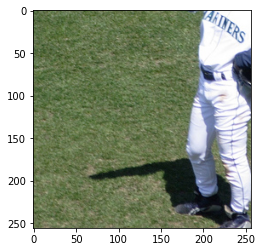

 [EVAL]: Do you like this image? [y/n]


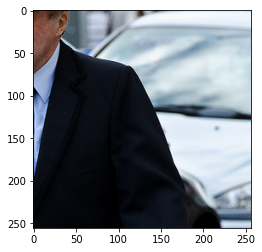

 [EVAL]: Do you like this image? [y/n]


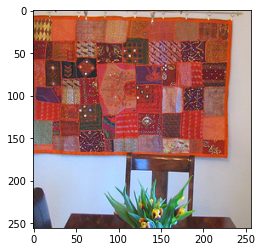

 [EVAL]: Do you like this image? [y/n]
 [EVAL]: Select level of noise [low, avg, max]
 [EVAL]: Noisy images.


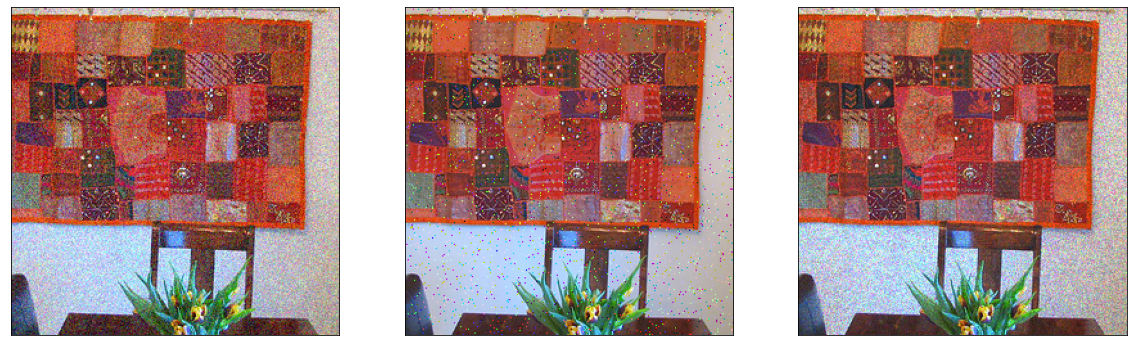

 [EVAL]: Denoised images.


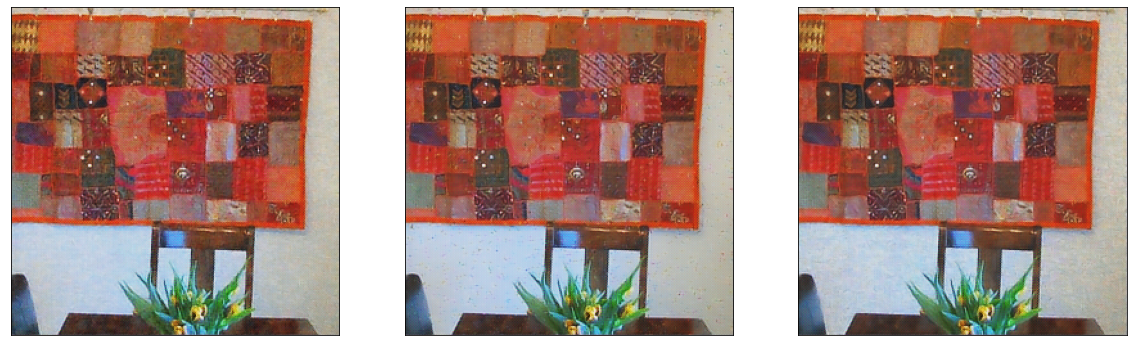

 [EVAL]: Again? [y/n]
**********************************************************************************
 [EVAL]: List of functionalities implemented:
 [EVAL]: 1. Show me best performance.
 [EVAL]: 2. Play with denoising of images.
 [EVAL]: 3. Back to menu.
**********************************************************************************
 [EVAL]: Play with images routine.
 [EVAL]: Which type of dataset you want to use as test set?
 [EVAL]: 1. COCO test.
 [EVAL]: 2. BSD.
22224896/22211847 [==============================] - 1s 0us/step


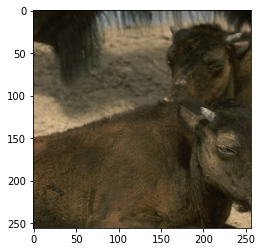

 [EVAL]: Do you like this image? [y/n]


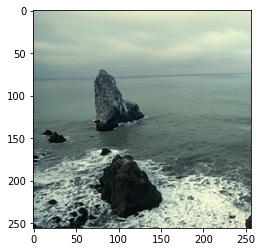

 [EVAL]: Do you like this image? [y/n]
 [EVAL]: Select level of noise [low, avg, max]
 [EVAL]: Noisy images.


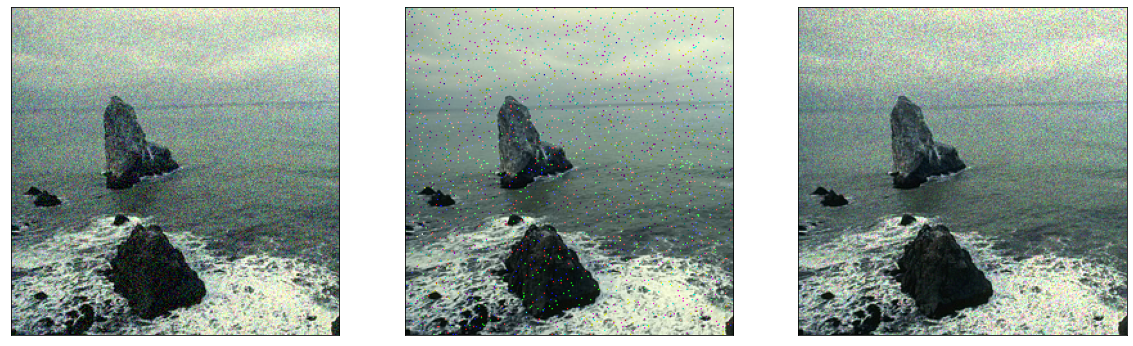

 [EVAL]: Denoised images.


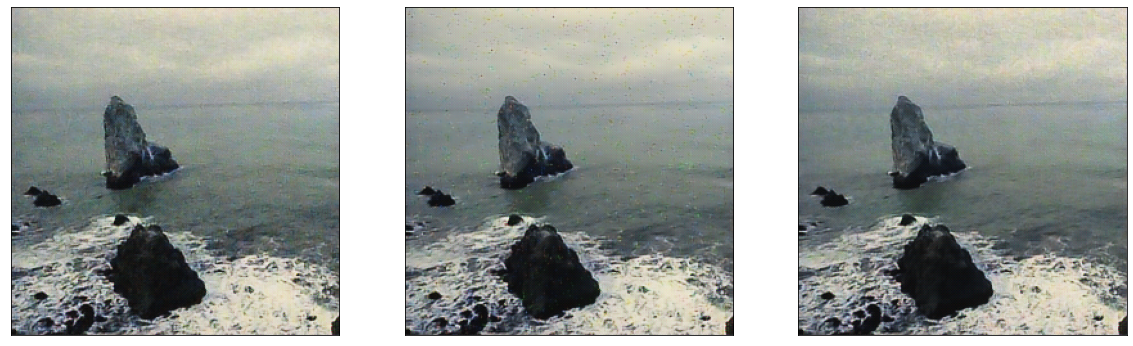

 [EVAL]: Again? [y/n]
 [EVAL]: Which type of dataset you want to use as test set?
 [EVAL]: 1. COCO test.
 [EVAL]: 2. BSD.


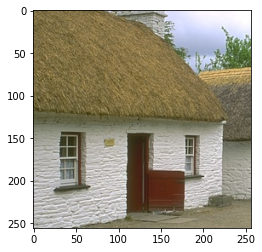

 [EVAL]: Do you like this image? [y/n]
 [EVAL]: Select level of noise [low, avg, max]
 [EVAL]: Noisy images.


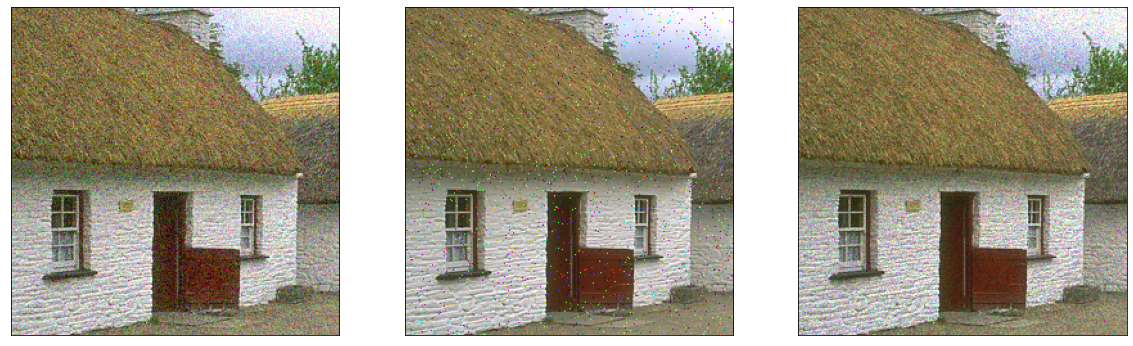

 [EVAL]: Denoised images.


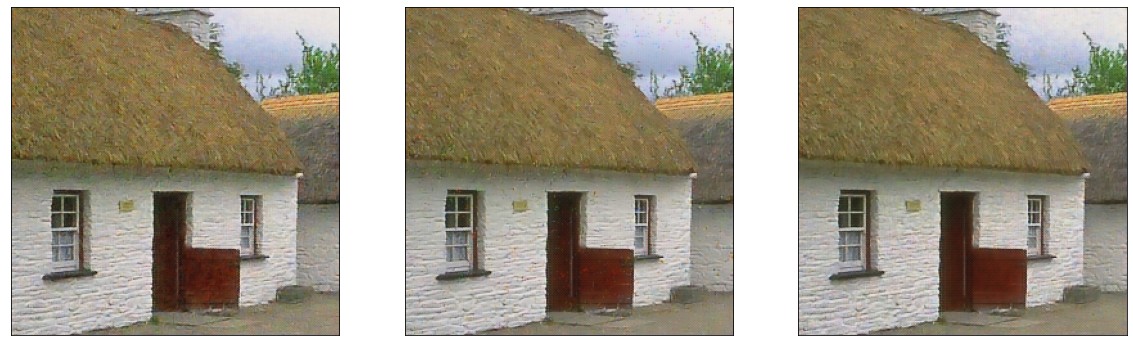

 [EVAL]: Again? [y/n]
 [EVAL]: Which type of dataset you want to use as test set?
 [EVAL]: 1. COCO test.
 [EVAL]: 2. BSD.


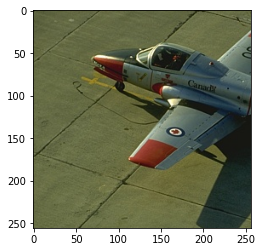

 [EVAL]: Do you like this image? [y/n]
 [EVAL]: Select level of noise [low, avg, max]
 [EVAL]: Noisy images.


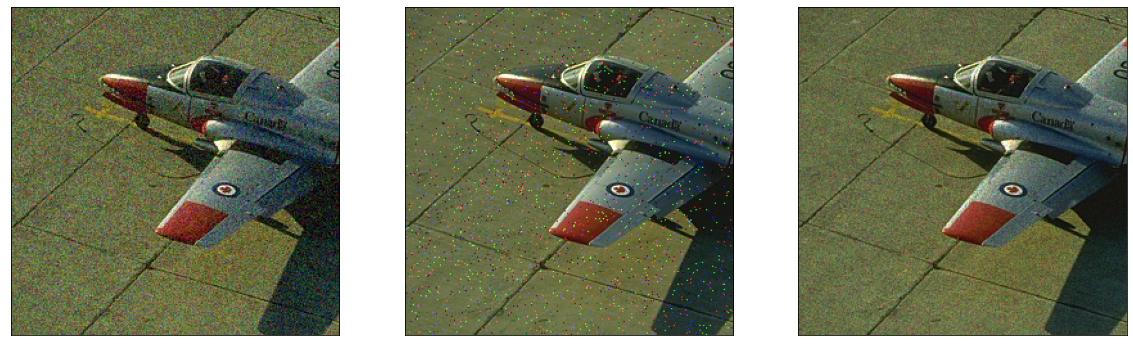

 [EVAL]: Denoised images.


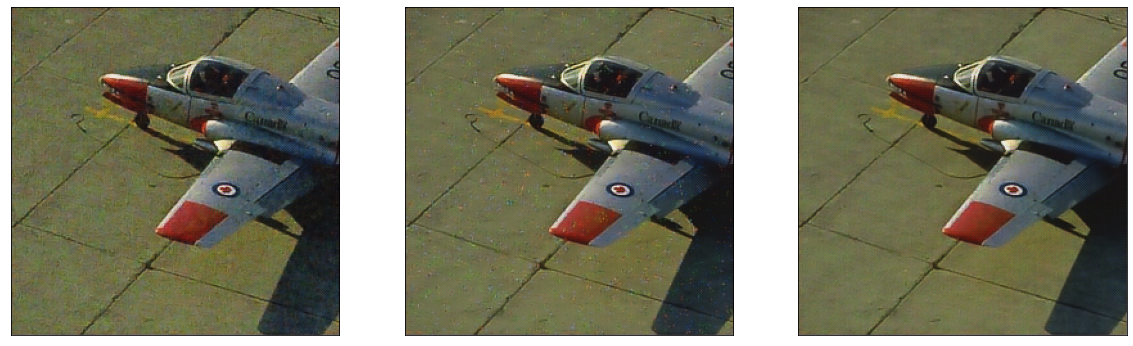

 [EVAL]: Again? [y/n]
**********************************************************************************
 [EVAL]: List of functionalities implemented:
 [EVAL]: 1. Show me best performance.
 [EVAL]: 2. Play with denoising of images.
 [EVAL]: 3. Back to menu.
**********************************************************************************
 [EVAL]: Show performance routine.
 [EVAL]: Showing loss/accuracy plots...


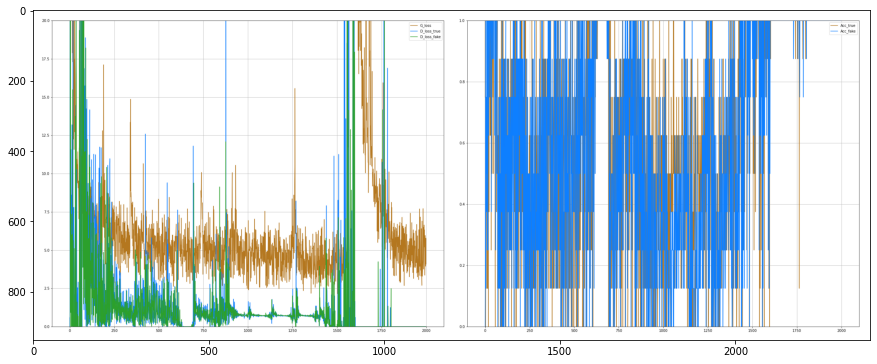

**********************************************************************************
 [EVAL]: On this trained model epoch 9 was chosen.
**********************************************************************************
 [EVAL]: Performance on PSNR and SSIM on TRAIN set.

 [PSNR]: AVG noise gaussian = 25.635015312263043
 [PSNR]: AVG noise s&p = 25.845360516177877
 [PSNR]: AVG noise speckle = 26.114924389715025

 [SSIM]: AVG noise gaussian = 0.7073333383188858
 [SSIM]: AVG noise s&p = 0.721206647935997
 [SSIM]: AVG noise speckle = 0.7373369969678114

 [PSNR]: MAX noise gaussian = 30.51915758653348
 [PSNR]: MAX noise s&p = 30.793600655058235
 [PSNR]: MAX noise speckle = 31.453475849306894

 [SSIM]: MAX noise gaussian  = 0.8885032687440159
 [SSIM]: MAX noise s&p  = 0.8967486117031083
 [SSIM]: MAX noise speckle  = 0.903329300452465
**********************************************************************************
 [EVAL]: Which type of dataset you want to use as test set?
 [EVAL]: 1. COCO tes

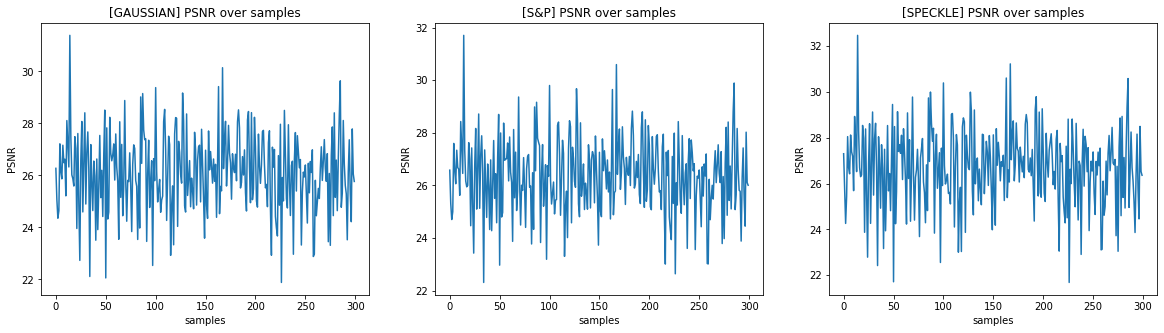

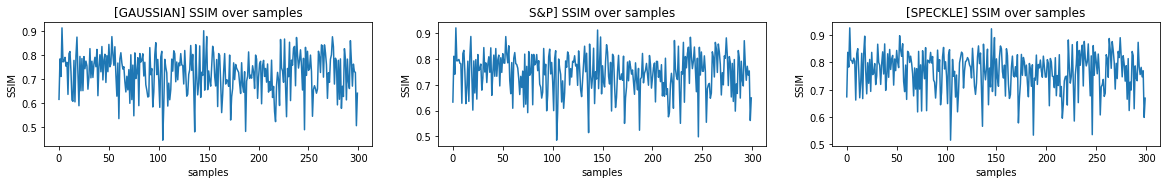

**********************************************************************************
 [EVAL]: List of functionalities implemented:
 [EVAL]: 1. Show me best performance.
 [EVAL]: 2. Play with denoising of images.
 [EVAL]: 3. Back to menu.


In [ ]:
# Execute this block code to see the demo
menu()